In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [14]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [15]:
len(words)

32033

In [16]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) * ((n_embd * block_size)** 0.5) # for tanh 5/3 is the gain we need to use
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [32]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 # + b1  hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi =  hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.1080
  20000/ 200000: 2.7056
  30000/ 200000: 2.1581
  40000/ 200000: 2.3510
  50000/ 200000: 1.9673
  60000/ 200000: 2.2058
  70000/ 200000: 2.4311
  80000/ 200000: 2.6161
  90000/ 200000: 2.2592
 100000/ 200000: 2.3973
 110000/ 200000: 2.4511
 120000/ 200000: 1.7488
 130000/ 200000: 2.1158
 140000/ 200000: 2.4020
 150000/ 200000: 2.1161
 160000/ 200000: 2.0824
 170000/ 200000: 2.3950
 180000/ 200000: 2.1838
 190000/ 200000: 2.1770


### To understand why scaling W1 and b1 gives you a “hockey stick” graph while scaling W2 and b2 does not, let’s dive deeper into the role of these layers in your neural network and how their initializations affect training.

### Key Differences

	1.	Role of Layers:
	•	W1 and b1: These are the weights and biases for the first (hidden) layer of the MLP (Multi-Layer Perceptron).
	•	W2 and b2: These are the weights and biases for the output layer of the MLP.
	2.	Impact of Initialization:
	•	Small Weights for W1 and b1:
	•	Initial Signal Strength: If W1 is very small, the initial signals (hidden activations) passing through the first layer will be very weak. This causes the gradients during backpropagation to be small, leading to very slow learning initially. This results in high loss that doesn’t decrease significantly at first, creating the “handle” of the hockey stick.
	•	Gradual Learning: As training progresses, the weights gradually adjust, eventually leading to a significant drop in loss, creating the “blade” of the hockey stick.
	•	Small Weights for W2 and b2:
	•	Output Layer Initialization: The impact of small initial weights in the output layer is less dramatic compared to the hidden layer. The hidden layer activations (output of the first layer) are already processed features, and the final adjustments in the output layer can more quickly correct the initial output to match the target.
	•	Smoother Learning Curve: The overall learning is smoother because the hidden layer is already providing useful features, even if the final layer’s adjustments start small.

#### Why Scaling W1 and b1 Creates a Hockey Stick Graph

	•	Small Gradient Flow: Small initial weights in W1 result in small gradients during the backward pass. This slow gradient flow means the model learns very slowly at first, leading to a high and stable initial loss.
	•	Delayed Improvement: Once the gradients start to make a noticeable impact (after many iterations), the loss begins to drop significantly, creating the sharp decline characteristic of a hockey stick graph.

#### Why Scaling W2 and b2 Does Not Create a Hockey Stick Graph

	•	Less Impact on Gradient Flow: Small initial weights in W2 do not significantly hinder the gradient flow as much because the hidden layer is already providing a rich set of features. The model can still learn effectively from the beginning.
	•	Steady Learning: The output layer’s small initial weights do not cause as significant a delay in learning, leading to a smoother, more consistent decline in loss.

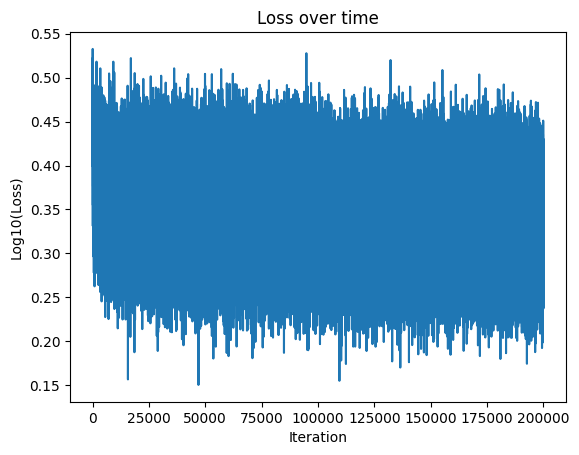

In [33]:
plt.plot(lossi)
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Log10(Loss)')
plt.show()

In [34]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    hpreact = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)  # (N, n,hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1734328269958496
val 2.187385082244873


In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

narmavelle.
hmvltrimmremleth.
hbrekk.
ljmrreth.
brjyvict.
ronixoh.
muk.
jahni.
bouxlukkphnn.
hbrwxiqwinnishoxlex.
janzikh.
jexlukkarbstxreth.
phrrdchrm.
zaxlakgrleshhwri.
hamarmide.
hushadsubbox.
zir.
joznngrian.
rhben.
kummnduxwentler.


In [37]:
h

tensor([[-1.0000, -0.9999,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
          1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000,
         -0.1627, -0.9639, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -0.1244,  1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,
         -0.9896, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -0.9999,  1.0000,
         -1.0000, -1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
          1.0000,  1.0000, -0.4620,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000,  

In [38]:
h.view(-1)

tensor([-1.0000, -0.9999,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
         1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000,
        -0.1627, -0.9639, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -0.1244,  1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,
        -0.9896, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -0.9999,  1.0000,
        -1.0000, -1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         1.0000,  1.0000, -0.4620,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000,  1.0000, -1.00

In [39]:
h.view(-1).tolist()

[-1.0,
 -0.9999452829360962,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -0.9999955892562866,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -0.16267099976539612,
 -0.9639084935188293,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 0.9999736547470093,
 -0.1243525892496109,
 1.0,
 -1.0,
 -0.9999998211860657,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -0.9895704984664917,
 -1.0,
 -1.0,
 1.0,
 0.9999951124191284,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -0.9998921155929565,
 1.0,
 -1.0,
 -1.0,
 0.9999876618385315,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -0.9999995827674866,
 -1.0,
 1.0,
 1.0,
 -0.4620041847229004,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.9999938011169434,
 -1.0,
 -1.0,
 0.9972714781761169,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 0.9999951

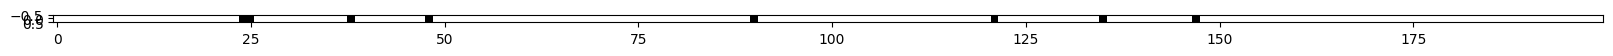

In [40]:
plt.figure(figsize=(20,10)) #if all the values are zero weight and biases never learn means it is a dead neuron
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

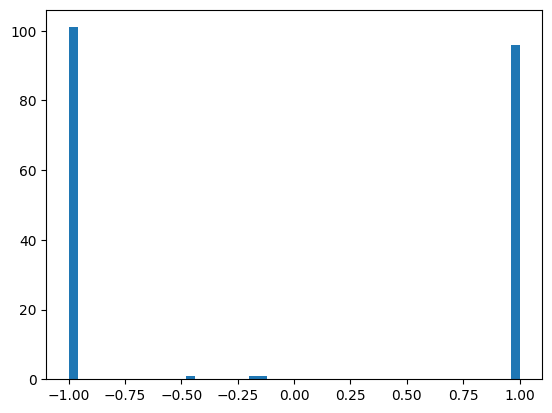

In [41]:
plt.hist(h.view(-1).tolist(),50); # most of the tanh values are -1 and 1 which in turn kills the gradient during back propagation if the tanh values
# are zero the gradient gets passed directly without doing anything. Since the values are in top or at the tail of the tanh when it is -1 and 1
# the value gets quashed. How much gets quashed depends upon how far it is on the tail or top 
# watch micrograd backward function to understand this better

(array([  1.,   0.,   0.,   0.,   1.,   1.,   1.,   7.,   7.,  13.,  27.,
         34.,  56.,  80.,  92., 152., 206., 195., 286., 309., 344., 394.,
        380., 446., 454., 441., 392., 386., 325., 273., 272., 205., 147.,
        124., 106.,  78.,  50.,  39.,  23.,  21.,  12.,   4.,   3.,   5.,
          3.,   0.,   0.,   0.,   0.,   5.]),
 array([-233.09983826, -223.29486298, -213.4898877 , -203.68491241,
        -193.87993713, -184.07496185, -174.26998657, -164.46501129,
        -154.66003601, -144.85506073, -135.05008545, -125.24511017,
        -115.44013489, -105.63515961,  -95.83018433,  -86.02520905,
         -76.22023376,  -66.41525848,  -56.6102832 ,  -46.80530792,
         -37.00033264,  -27.19535736,  -17.39038208,   -7.5854068 ,
           2.21956848,   12.02454376,   21.82951904,   31.63449432,
          41.4394696 ,   51.24444489,   61.04942017,   70.85439545,
          80.65937073,   90.46434601,  100.26932129,  110.07429657,
         119.87927185,  129.68424713,  139.489

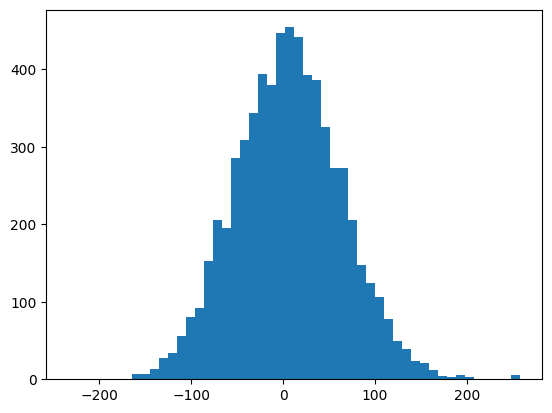

In [42]:
plt.hist(hpreact.view(-1).tolist(),50) # the values are quite broader

tensor(-0.0058) tensor(0.9950)
tensor(-0.0002) tensor(1.0016)


(array([2.11207669e-05, 0.00000000e+00, 0.00000000e+00, 2.11207669e-05,
        2.11207669e-05, 1.05603835e-04, 1.05603835e-04, 3.80173805e-04,
        4.01294572e-04, 6.75864542e-04, 9.29313745e-04, 1.98535209e-03,
        3.29483964e-03, 5.13234637e-03, 9.20865439e-03, 1.57772129e-02,
        2.30638775e-02, 3.45535747e-02, 5.48717525e-02, 8.34270294e-02,
        1.20409492e-01, 1.66727334e-01, 2.28294370e-01, 2.96451085e-01,
        3.60890545e-01, 4.07482957e-01, 4.33799432e-01, 4.26681734e-01,
        3.79497940e-01, 3.19071426e-01, 2.50893591e-01, 1.89284313e-01,
        1.35595324e-01, 9.48533643e-02, 6.34256631e-02, 4.37622291e-02,
        2.85763977e-02, 1.70233382e-02, 1.00323643e-02, 6.63192082e-03,
        4.41424029e-03, 2.70345817e-03, 1.68966136e-03, 7.81468377e-04,
        5.91381474e-04, 3.80173805e-04, 1.26724602e-04, 4.22415339e-05,
        2.11207669e-05, 4.22415339e-05]),
 array([-6.31793737, -6.08120355, -5.84446972, -5.60773589, -5.37100206,
        -5.13426824, 

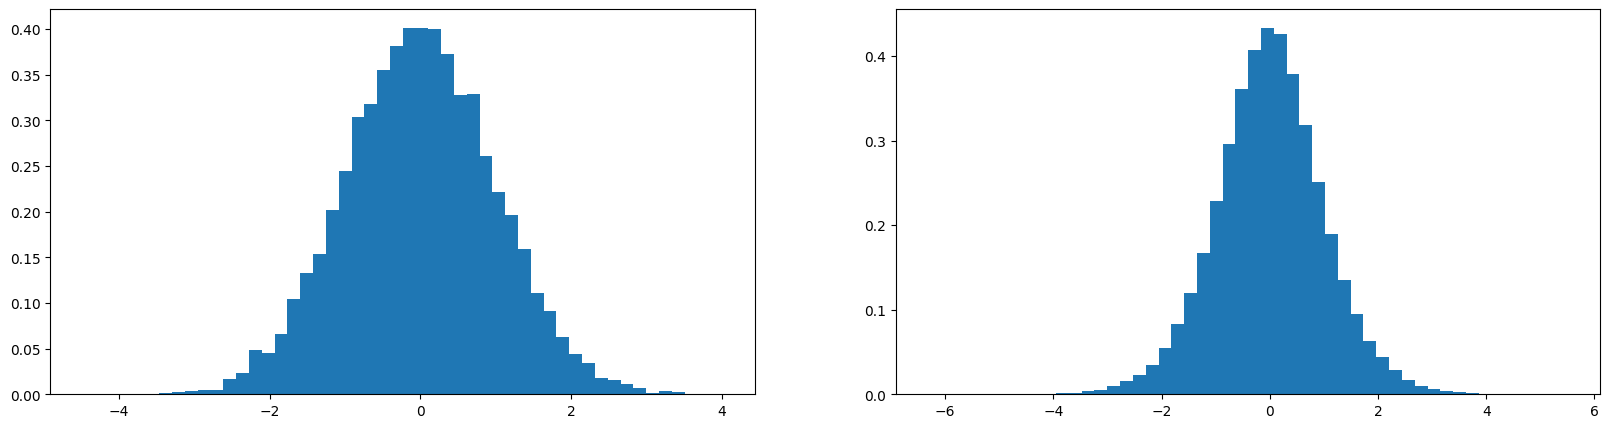

In [43]:
x = torch.randn(1000,10)
w = torch.randn(10,200) /10**0.5 # root over fan_in/input. since tanh and relu squeezes in if the value are -ve or +ve so to boost the values 
# to make the std deviation as gaussian distribution
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [44]:
hpreact.shape

torch.Size([32, 200])

In [45]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [46]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [47]:
bnmean

tensor([[-22.0596,   5.4846, -62.6702,  20.3101,  23.5537,  31.4836,  44.8540,
         -30.1119,  -0.2477,  18.5064, -30.8401, -51.9340,  16.8937, -12.6184,
           8.1357,  39.4107,  41.4595, -33.9596, -16.0346,  31.4723,  23.6383,
          -4.8234,  -8.3356,  15.0444,   9.0332,  29.4352,  24.1073,  -0.8950,
          -3.3454,  41.4099,  -2.5185, -37.7088,  11.9481,   7.9834,  -0.2712,
         -12.7195, -27.0202, -19.0378,   1.1521,  29.8906,  13.7051, -24.2856,
         -23.5861,  14.3501,  27.7544,   1.9178,  11.1421,  -7.7575,  27.8659,
          36.0394,  17.1502,  22.6517,  46.3052,  57.5195,  35.8778, -45.4140,
           4.4884,   4.3883,  29.0270, -34.1584, -11.0401,   4.2078,   8.8016,
          21.8998,  31.6522,  35.2233,   8.6634,  26.6341,  -4.2822, -19.1248,
           9.2323,  17.5012,  23.9642, -32.8915, -35.8425,  10.0709,  21.6990,
           5.4845,  35.3624, -13.9058,  45.2416,  30.6866,  36.7135,   8.0243,
           5.6402, -17.7538, -60.9668,  14.0301,  38

In [48]:
bnmean_running

tensor([[-22.5811, -10.4260, -56.7904,  18.4928,  29.7907,  26.0880,  54.9029,
         -34.9429, -12.4293,  35.3455, -37.2306, -57.5386,   9.1594, -12.1487,
           8.4151,  26.0280,  24.1507, -47.3922, -29.8536,  30.4629,  20.7248,
         -22.7562, -22.6633,  23.5409,  17.7845,  28.2846,  22.8238, -16.3592,
           5.6595,  46.8640, -21.0371, -28.7480,   7.8628,  16.7969, -17.1901,
         -17.9569, -16.7265, -31.0500,  -2.7141,  32.5917,  13.0234, -25.3962,
         -32.8821,   8.2684,  13.0761,  -0.4456,  12.4373, -10.5195,  26.2846,
          49.0939,  18.0780,  21.8437,  50.8911,  62.8226,  32.8864, -43.0815,
         -14.7344,  19.9511,  47.8200, -42.1705, -10.8003,  15.4173,  16.9474,
          15.5196,  44.2818,  13.3642,  21.3780,  30.3177,  -8.9638, -13.9704,
           0.6724,  27.5038,  28.2536, -32.3938, -40.1963,  10.3958,  34.8953,
          -2.0728,  31.7286,  -7.4178,  36.6058,  50.3986,  47.4814,   4.6075,
          13.6400, -25.7226, -55.3476,   7.2988,  41